In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import optuna


import warnings
warnings.filterwarnings('ignore')

In [307]:
data = pd.read_csv('datasets/ufc-master.csv')

Удаляем ненужные признаки

In [308]:
valuable_features = ['RedFighter',
                     'BlueFighter',                  
                     'WeightClass',
                     'Gender',
                     'Winner',
                     'Finish',
                     'NumberOfRounds',
                     'RedAge',
                     'RedHeightCms',
                     'RedReachCms',
                     'RedWeightLbs',
                     'RedStance',
                     'RedWins',
                     'RedWinsByDecisionMajority',
                     'RedWinsByDecisionSplit',
                     'RedWinsByDecisionUnanimous',
                     'RedWinsByKO',
                     'RedWinsByTKODoctorStoppage',
                     'RedWinsBySubmission',
                     'RedCurrentWinStreak',
                     'RedLosses',
                     'RedCurrentLoseStreak',
                     'RedAvgSigStrLanded',
                     'RedAvgSigStrPct',                     
                     'RedAvgSubAtt',
                     'RedAvgTDLanded',
                     'RedAvgTDPct',
                     'RedTotalRoundsFought',
                     'BlueAge',
                     'BlueHeightCms',
                     'BlueReachCms',
                     'BlueWeightLbs',
                     'BlueStance',
                     'BlueWins',
                     'BlueWinsByDecisionMajority',
                     'BlueWinsByDecisionSplit',
                     'BlueWinsByDecisionUnanimous',
                     'BlueWinsByKO',
                     'BlueWinsByTKODoctorStoppage',
                     'BlueWinsBySubmission',
                     'BlueCurrentWinStreak',
                     'BlueLosses', 
                     'BlueCurrentLoseStreak',                    
                     'BlueAvgSigStrLanded',                 # Среднее количество значимых ударов, выбрасываемых в минуту синим бойцом
                     'BlueAvgSigStrPct',                    # Соотношение значимых попаданий к общему количеству значимых ударов для синего бойца   
                     'BlueAvgSubAtt',                       # Среднее количесвто попыток болевого приема за 15 минут для синего бойца
                     'BlueAvgTDLanded',                     # Среднее количесвто тейкдаунов за 15 минут для синего бойца
                     'BlueAvgTDPct',                        # Соотношение успешных тейкдаунов к общему количеству попыток для синего бойца
                     'BlueTotalRoundsFought'
                    ]

data = data[valuable_features]

Объединяем признаки `Winner` и `Finish` в один признак `Result`

In [309]:
def def_target(row):
    if row['Winner'] == 'Red':
        if row['Finish'] == 'KO/TKO':
            return 'Red-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Red-Submission'
        else:
            return 'Red-Decision'
    if row['Winner'] == 'Blue':
        if row['Finish'] == 'KO/TKO':
            return 'Blue-KO/TKO'
        elif row['Finish'] == 'SUB':
            return 'Blue-Submission'
        else:
            return 'Blue-Decision'
        
data['Result'] = data.apply(def_target, axis=1)

Объединим несколько признаков между собой для того, чтобы уменьшить количество признаков

In [310]:
data['RedWinsByDecision'] = data['RedWinsByDecisionMajority'] + data['RedWinsByDecisionSplit'] + data['RedWinsByDecisionUnanimous']
data['RedWinsByKO/TKO'] = data['RedWinsByKO'] + data['RedWinsByTKODoctorStoppage']

data['BlueWinsByDecision'] = data['BlueWinsByDecisionMajority'] + data['BlueWinsByDecisionSplit'] + data['BlueWinsByDecisionUnanimous']
data['BlueWinsByKO/TKO'] = data['BlueWinsByKO'] + data['BlueWinsByTKODoctorStoppage']

# Удалим лишние признаки
columns_to_drop = ['RedWinsByDecisionMajority',
                   'RedWinsByDecisionSplit',
                   'RedWinsByDecisionUnanimous',
                   'RedWinsByKO',
                   'RedWinsByTKODoctorStoppage',
                   'BlueWinsByDecisionMajority',
                   'BlueWinsByDecisionSplit',
                   'BlueWinsByDecisionUnanimous',
                   'BlueWinsByKO',
                   'BlueWinsByTKODoctorStoppage',
                   'Winner',
                   'Finish'
                   #'RedWeightLbs',
                   #'BlueWeightLbs'                          
                    ]

data = data.drop(columns=columns_to_drop, axis=1)

Бинарные и ориднильные признаки можно преобразовать в числовой вид 

In [311]:
binary_features = ['Gender', 'NumberOfRounds', 'RedStance', 'BlueStance']
data['Gender'] = data['Gender'].map({'FEMALE': 0, 'MALE': 1})
data['NumberOfRounds'] = data['NumberOfRounds'].map({3: 0, 5: 1})
data['RedStance'] = data['RedStance'].map({'Southpaw': 0, 'Orthodox': 1})
data['BlueStance'] = data['BlueStance'].map({'Southpaw': 0, 'Orthodox': 1})

ordinal_features = ['WeightClass', 'Result']
data['WeightClass'] = data['WeightClass'].map({"Women's Strawweight": 0,
                                               'Flyweight': 0,
                                               "Women's Flyweight": 0,
                                               'Bantamweight': 1,
                                               "Women's Bantamweight": 1,
                                               'Featherweight': 2,
                                               "Women's Featherweight": 2,
                                               'Catch Weight': 2,
                                               'Lightweight': 3,
                                               'Welterweight': 4,
                                               'Middleweight': 5,
                                               'Light Heavyweight': 6,
                                               'Heavyweight': 7})

data['Result'] = data['Result'].map({'Red-KO/TKO': 0,
                                     'Red-Submission': 1,
                                     'Red-Decision': 2,
                                     'Blue-KO/TKO': 3,
                                     'Blue-Submission' : 4,
                                     'Blue-Decision': 5                                     
                                    })

Бинаризуем `Result`

In [312]:
data['Result'] = data['Result'].isin([1, 3, 5]).astype(int)

Проверяем наличие пропусков

In [313]:
def check_columns_with_nans(df):
    for col in df.columns:
        isna_sum = 0
        if df[col].isna().any():
            isna_sum = df[col].isna().sum()
            print(f'{col}: {isna_sum}')

check_columns_with_nans(data)

NumberOfRounds: 21
RedStance: 375
RedAvgSigStrLanded: 455
RedAvgSigStrPct: 357
RedAvgSubAtt: 357
RedAvgTDLanded: 357
RedAvgTDPct: 367
BlueStance: 410
BlueAvgSigStrLanded: 930
BlueAvgSigStrPct: 765
BlueAvgSubAtt: 832
BlueAvgTDLanded: 833
BlueAvgTDPct: 842


In [314]:
data['NumberOfRounds'] = data['NumberOfRounds'].fillna(0)
data['RedStance'] = data['RedStance'].fillna(1)
data['BlueStance'] = data['BlueStance'].fillna(1)

Исправляем ошибки в статистических данных

In [315]:
stats_columns = ['RedAvgSigStrLanded',
                'BlueAvgSigStrLanded',
                'RedAvgSigStrPct',
                'BlueAvgSigStrPct',
                'RedAvgSubAtt',
                'BlueAvgSubAtt',
                'RedAvgTDLanded',
                'BlueAvgTDLanded',
                'RedAvgTDPct',
                'BlueAvgTDPct'
                ]   

def stats_columns_hist(df, columns):
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 19))
    for i in range(len(columns)):
        axs[int(i // 2), i % 2].hist(df[columns[i]], bins=30)
        axs[int(i // 2), i % 2].set_title(columns[i])
        axs[int(i // 2), i % 2].grid()

# stats_columns_hist(data, stats_columns)

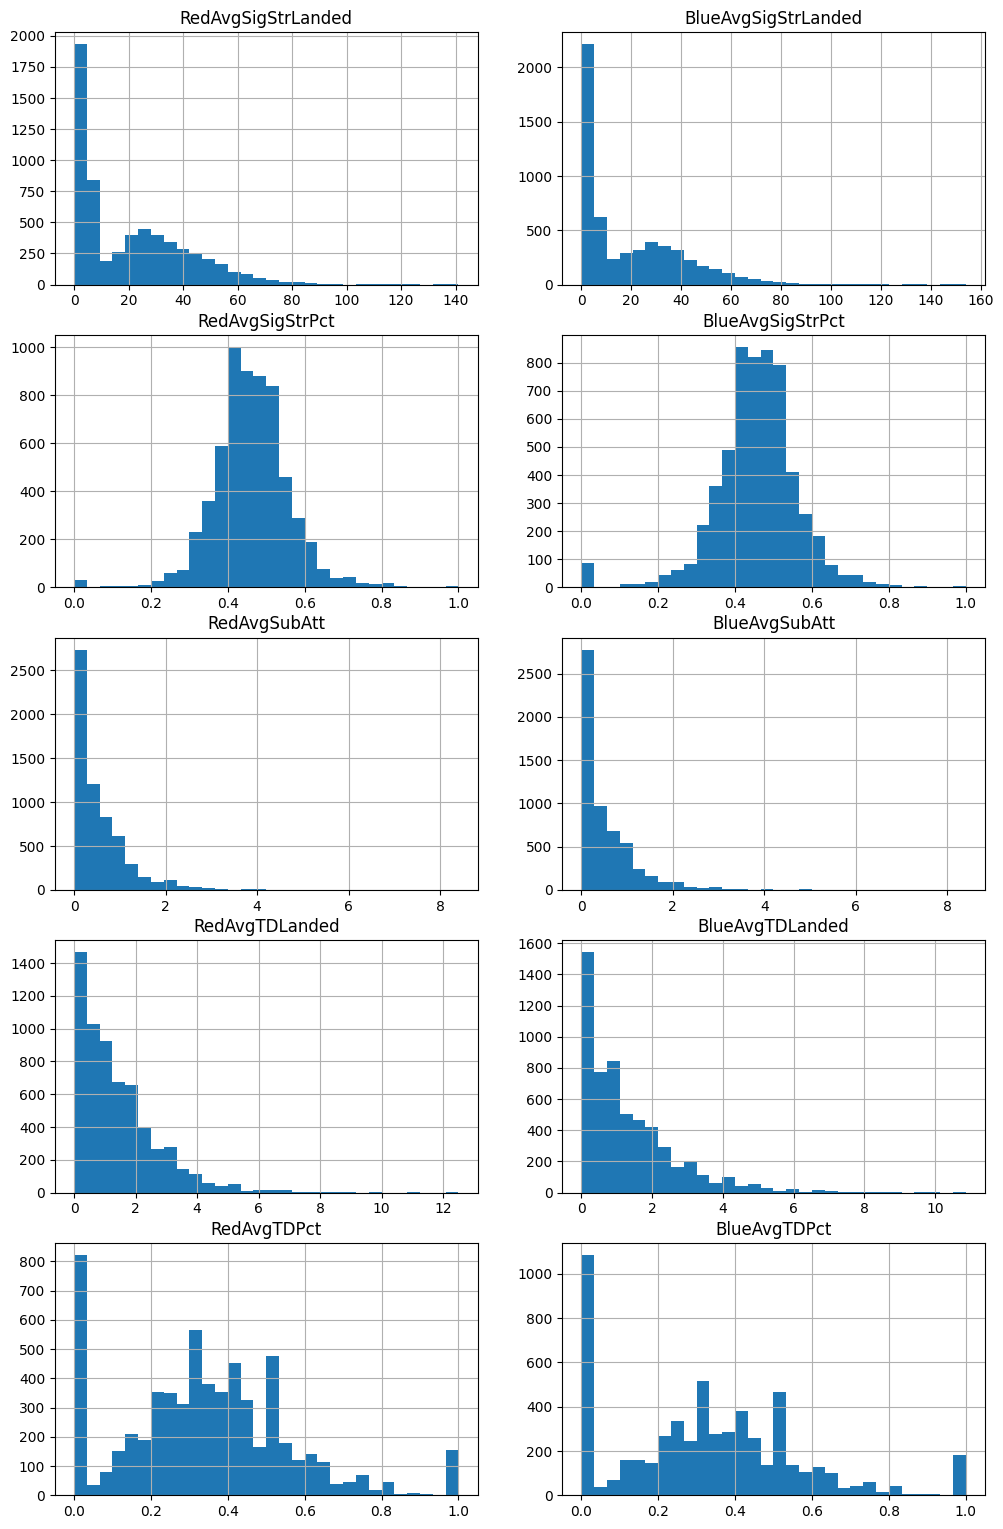

In [316]:
stats_columns_hist(data, stats_columns)

In [317]:
data.loc[2700:2710, ['RedFighter', 'RedAvgSigStrLanded', 'BlueFighter', 'BlueAvgSigStrLanded']]

,RedFighter,RedAvgSigStrLanded,BlueFighter,BlueAvgSigStrLanded
2700,Darren Elkins,3.27,Ryan Hall,2.32
2701,Liu Pingyuan,2.36,Jonathan Martinez,3.67
2702,Livinha Souza,1.79,Brianna Van Buren,4.80
2703,Benito Lopez,4.49,Vince Morales,4.84
2704,Jon Jones,4.30,Thiago Santos,4.44
2705,Amanda Nunes,4.34,Holly Holm,2.75
2706,Jorge Masvidal,4.33,Ben Askren,3.64
2707,Jan Blachowicz,3.45,Luke Rockhold,4.18
2708,Diego Sanchez,2.73,Michael Chiesa,2.07
2709,Gilbert Melendez,3.44,Arnold Allen,3.19


In [318]:
# data = data.drop(columns=['RedFighter', 'BlueFighter', 'RedAvgSigStrLanded', 'BlueAvgSigStrLanded'], axis=1)
# data = data.dropna()
# data

In [319]:
# data.to_csv('X_y_5500.csv')

### Разделяем выборку на Train и Test

In [320]:
# data = data.iloc[:2000, :]

In [321]:
# X = data.drop(columns=['Result'], axis=1)
# y = data['Result']
# X = data.drop(columns=['RedFighter', 'BlueFighter'])

# test_size = int(len(X)*0.2)
# test_size = 200
# X_train = X.iloc[test_size:, :]
# # y_train = y.iloc[test_size:]

# X_test = X.iloc[:test_size, :]
# y_test = y.iloc[:test_size]

In [322]:
check_columns_with_nans(data)

RedAvgSigStrLanded: 455
RedAvgSigStrPct: 357
RedAvgSubAtt: 357
RedAvgTDLanded: 357
RedAvgTDPct: 367
BlueAvgSigStrLanded: 930
BlueAvgSigStrPct: 765
BlueAvgSubAtt: 832
BlueAvgTDLanded: 833
BlueAvgTDPct: 842


### Исправление данных по статистикам бойцов

In [323]:
# Составим список всех бойцов в датасете
fighters = list(set(data['RedFighter'].unique()) & set(data['BlueFighter'].unique()))
len(fighters)

1471

In [337]:
data[data['BlueFighter'] == 'Petr Yan']['BlueAvgSigStrLanded']
data[data['RedFighter'] == 'Petr Yan']['RedAvgSigStrLanded']

FightNumber
14      5.11
407     5.14
908     5.14
1091    5.14
1587    5.14
1919    5.99
2261    5.65
3114    5.65
Name: RedAvgSigStrLanded, dtype: float64

In [327]:
# Добавим порядковый номер боя, чтобы не сбиться
data['FightNumber'] = np.arange(len(data))

In [334]:
# Определяем аномалии по заданной эвристике
red_anomaly_mask = data['RedAvgSigStrLanded'] >= 10
blue_anomaly_mask = data['BlueAvgSigStrLanded'] >= 10

# Функция для замены аномальных цен на ближайшую реальную
def replace_anomalies(group, column):
    # Удаляем аномалии
    clean_group = group[group[column] < 10]
    
    # Если группа не пуста, заменяем аномалии на ближайшую реальную цену
    if not clean_group.empty:
        nearest_value = clean_group[column].iloc[-1]  # Берем последнюю реальную цену
        
        # Заменяем аномалии на ближайшую реальную цену
        group.loc[group[column] >= 10, column] = nearest_value
        group.loc[group[column].isna(), column] = nearest_value
        
    return group

# Заменяем аномалии для каждого бойца
temp = data.groupby('RedFighter').apply(replace_anomalies, column='RedAvgSigStrLanded')
temp = temp.drop('RedFighter', axis=1).reset_index()
temp = temp.sort_values(by='level_1')
temp = temp.groupby('BlueFighter').apply(replace_anomalies, column='BlueAvgSigStrLanded')
temp = temp.drop(['BlueFighter', 'level_1'], axis=1).reset_index()
data = temp.drop('level_1', axis=1).sort_values(by='FightNumber')
data.set_index('FightNumber', inplace=True)
data

,BlueFighter,RedFighter,WeightClass,Gender,NumberOfRounds,RedAge,RedHeightCms,RedReachCms,RedWeightLbs,RedStance,...,BlueAvgSigStrPct,BlueAvgSubAtt,BlueAvgTDLanded,BlueAvgTDPct,BlueTotalRoundsFought,Result,RedWinsByDecision,RedWinsByKO/TKO,BlueWinsByDecision,BlueWinsByKO/TKO
FightNumber,,,,,,,,,,,,,,,,,,,,,
0,Kai Asakura,Alexandre Pantoja,0,1,1.0,34,165.10,170.18,125,1.0,...,0.00,0.0000,0.0000,0.00,0,1,6,2,0,0
1,Ian Machado Garry,Shavkat Rakhmonov,4,1,0.0,30,185.42,195.58,170,1.0,...,0.55,0.3000,0.7700,0.55,20,0,0,1,5,3
2,Alexander Volkov,Ciryl Gane,7,1,0.0,34,193.04,205.74,245,1.0,...,0.57,0.2000,0.4500,0.63,44,0,3,4,5,6
3,Kron Gracie,Bryce Mitchell,2,1,0.0,30,177.80,177.80,145,0.0,...,0.44,0.5000,0.4700,0.25,7,0,6,0,0,0
4,Dooho Choi,Nate Landwehr,2,1,0.0,36,175.26,182.88,145,1.0,...,0.53,0.8000,0.7500,0.37,15,1,2,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,Darren Elkins,Duane Ludwig,3,1,0.0,31,177.80,177.80,170,1.0,...,NaN,NaN,NaN,NaN,0,1,1,1,0,0
6524,Daniel Roberts,John Howard,4,1,0.0,27,170.18,180.34,170,1.0,...,NaN,NaN,NaN,NaN,0,0,2,1,0,0
6525,Chase Gormley,Brendan Schaub,7,1,0.0,27,193.04,198.12,245,1.0,...,0.34,1.0000,1.0000,1.00,1,0,0,0,0,0


In [343]:
data_final = data[(data['RedAvgSigStrLanded'] < 10) & (data['BlueAvgSigStrLanded'] < 10)]

### Убираем выбросы в Train

In [49]:
# stats_columns_hist(X_test, stats_columns)

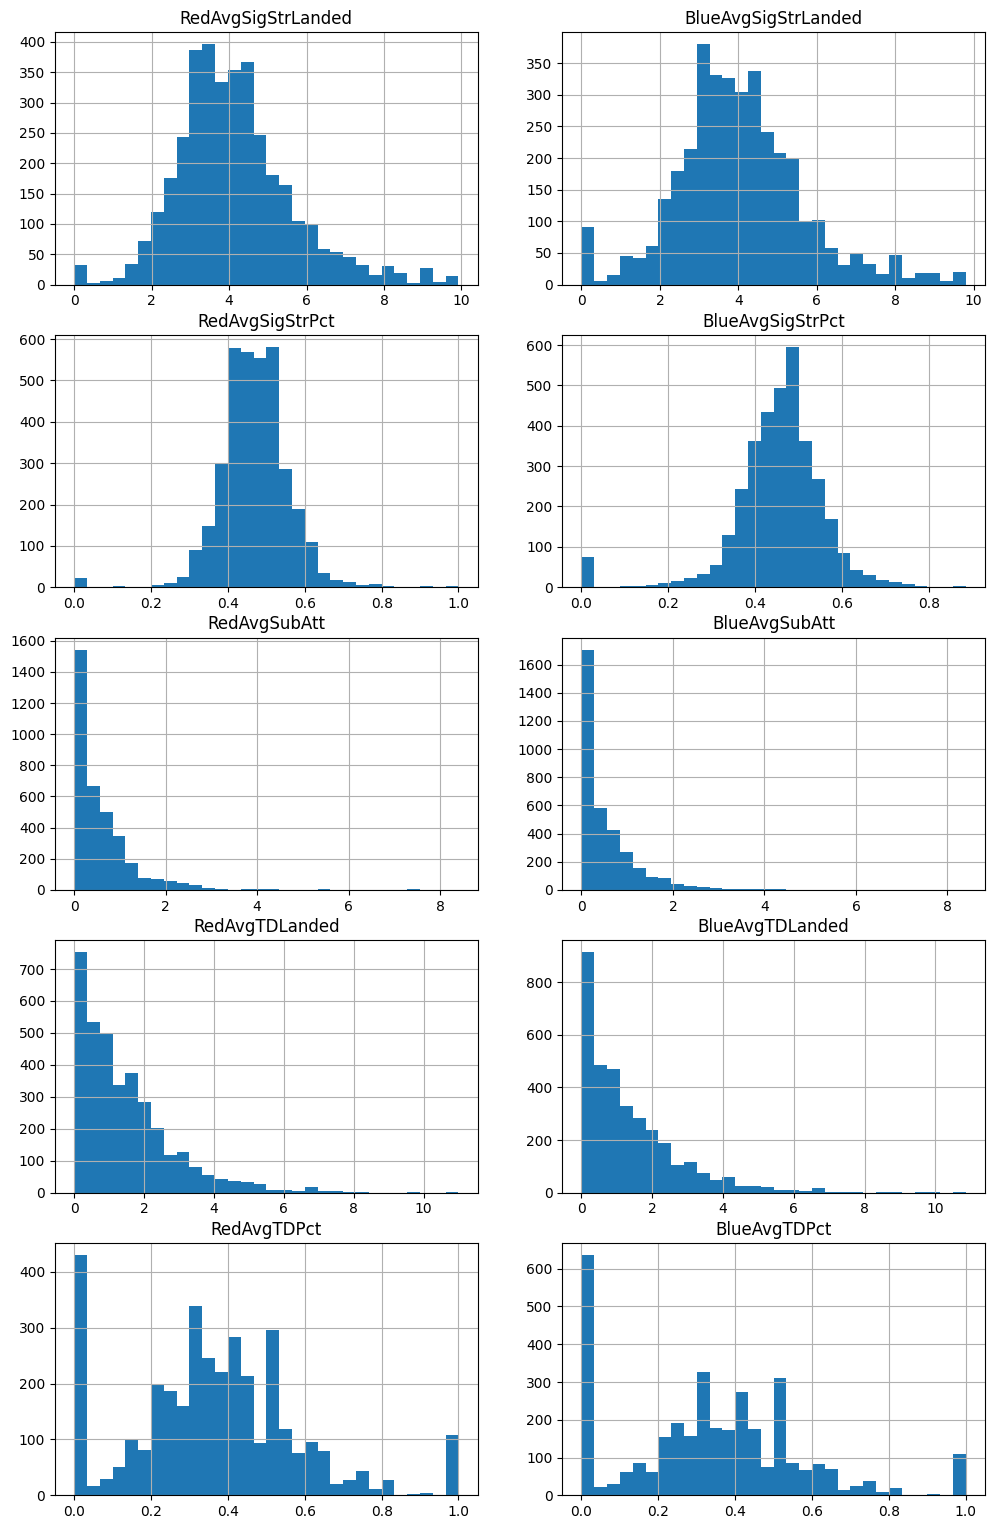

In [344]:
stats_columns_hist(data_final, stats_columns)

In [51]:
# def replace_outliers_with_nearest_quantile(df, columns): 
              
#     for column_name in columns:            
#         # Рассчитать первый и третий квартили
#         q1 = df[column_name].quantile(0.25)
#         q3 = df[column_name].quantile(0.75)
        
#         # Рассчитать межквантильный диапазон (IQR)
#         iqr = q3 - q1
        
#         # Определить нижнюю и верхнюю границы для аномалий
#         lower_bound = q1 - 3.5 * iqr
#         upper_bound = q3 + 3.5 * iqr            
        
#         # Заменить аномальные значения на ближайший квантиль
#         df.loc[df[column_name] < lower_bound, column_name] = q1
#         df.loc[df[column_name] > upper_bound, column_name] = q3
    
#     return df

In [19]:
# X_train.loc[X_train['RedAvgSigStrLanded'] > 10, 'RedAvgSigStrLanded'] = 4.13
# X_train.loc[X_train['BlueAvgSigStrLanded'] > 10, 'BlueAvgSigStrLanded'] = 4.08

In [350]:
check_columns_with_nans(data_final)

In [ ]:
X_train

In [22]:
# X_train = X_train.dropna()

### Заполняем NaN в Train

In [346]:
def replace_nan_with_median(df, columns):
    
    # Создать копию датафрейма для изменения
    df_copy = df.copy()
    
    # Заменить NaN значения на медианное значение для каждого столбца
    for column_name in columns:
        if column_name in df_copy.columns:
            median_value = df_copy[column_name].median()
            df_copy[column_name] = df_copy[column_name].fillna(median_value)
        else:
            print(f"Столбец '{column_name}' не найден в датафрейме.")
    
    return df_copy

In [348]:
data_final = replace_nan_with_median(data_final, stats_columns)

### Обучаем модель

In [353]:
X = data_final.drop(columns=['RedFighter', 'BlueFighter', 'Result'])

test_size = int(len(X)*0.2)
# test_size = 200
X_train = X.loc[test_size:, :]
y_train = data_final.loc[test_size:, 'Result']

X_test = X.loc[:test_size, :]
y_test = data_final.loc[:test_size, 'Result']

In [16]:
# y_train = X_train['Result']
# y_test = X_test['Result']

# X_train = X_train.drop(columns=['Result'], axis=1)
# X_test = X_test.drop(columns=['Result'], axis=1)

In [75]:
X_to_export = pd.concat([X_test.drop(columns=['RedAvgSigStrLanded', 'BlueAvgSigStrLanded'], axis=1),
                         X_train.drop(columns=['RedAvgSigStrLanded', 'BlueAvgSigStrLanded'], axis=1)],
                         axis=0)

X_to_export.to_csv('X_2000.csv')

y_to_export = pd.concat([y_test, y_train], axis=0)
y_to_export.to_csv('y_2000.csv')

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&M

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       389
           1       0.59      0.59      0.59       335

    accuracy                           0.62       724
   macro avg       0.62      0.62      0.62       724
weighted avg       0.62      0.62      0.62       724



Text(0.5, 23.52222222222222, 'predicted value')

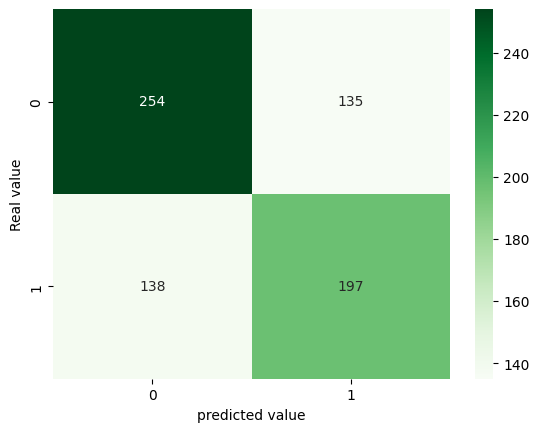

In [358]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', MinMaxScaler()),
                     ('logreg', LogisticRegression(max_iter=1000))
                     ])

params = {'logreg__penalty': [None, 'l1', 'l2'],
          'logreg__C': np.linspace(0.001, 10000, 24),
          'logreg__solver': ['liblinear', 'lbfgs', 'newton-cs'],
          'logreg__class_weight': ['none', 'balanced'],
          'logreg__fit_intercept': [True, False]}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

gs_binary = GridSearchCV(estimator=pipeline, param_grid=params, cv=folds, scoring='f1', verbose=True, n_jobs=-1)

# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [359]:
def optimize_and_train(X_train, y_train, X_test, y_test, n_trials=20):
    # Определение пайплайна
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('logreg', LogisticRegression(max_iter=1000))
    ])

    # Определение кросс-валидации
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

    # Функция для оценки модели
    def objective(trial):
        # Определение пространства поиска гиперпараметров
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        C = trial.suggest_loguniform('C', 0.001, 10000)
        solver = trial.suggest_categorical('solver', ['liblinear'])
        class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
        fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
        
        # Установка гиперпараметров
        pipeline.set_params(
            logreg__penalty=penalty,
            logreg__C=C,
            logreg__solver=solver,
            logreg__class_weight=class_weight,
            logreg__fit_intercept=fit_intercept
        )
        
        # Кросс-валидация
        scores = cross_val_score(pipeline, X_train, y_train, cv=folds, scoring='f1')
        return scores.mean()

    # Создание и запуск оптимизатора
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    # Лучшие гиперпараметры
    best_params = study.best_params
    print("Best parameters:", best_params)

    # Обучаем пайплайн с лучшими гиперпараметрами
    pipeline.set_params(
        logreg__penalty=best_params['penalty'],
        logreg__C=best_params['C'],
        logreg__solver=best_params['solver'],
        logreg__class_weight=best_params['class_weight'],
        logreg__fit_intercept=best_params['fit_intercept']
    )
    pipeline.fit(X_train, y_train)

    # Делаем прогнозы на тестовых данных
    y_pred = pipeline.predict(X_test)

    # Определяем вероятности
    y_proba = pipeline.predict_proba(X_test)

    # Выводим метрики качества модели
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Матрица ошибок
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap='Greens')
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.show()

    return pipeline, y_pred, y_proba, pipeline

[I 2025-01-16 00:47:59,087] A new study created in memory with name: no-name-0709a437-909c-4e56-b1ea-e097fab46a36
[I 2025-01-16 00:47:59,771] Trial 0 finished with value: 0.5743536313173419 and parameters: {'penalty': 'l1', 'C': 6.332005768003595, 'solver': 'liblinear', 'class_weight': 'balanced', 'fit_intercept': False}. Best is trial 0 with value: 0.5743536313173419.
[I 2025-01-16 00:48:00,355] Trial 1 finished with value: 0.5125002865493627 and parameters: {'penalty': 'l1', 'C': 4709.28421697028, 'solver': 'liblinear', 'class_weight': None, 'fit_intercept': False}. Best is trial 0 with value: 0.5743536313173419.
[I 2025-01-16 00:48:00,427] Trial 2 finished with value: 0.3264040177375386 and parameters: {'penalty': 'l2', 'C': 0.04702059864639193, 'solver': 'liblinear', 'class_weight': None, 'fit_intercept': True}. Best is trial 0 with value: 0.5743536313173419.
[I 2025-01-16 00:48:00,582] Trial 3 finished with value: 0.5724906059882049 and parameters: {'penalty': 'l1', 'C': 0.2895894

Best parameters: {'penalty': 'l1', 'C': 0.8243937182611414, 'solver': 'liblinear', 'class_weight': 'balanced', 'fit_intercept': True}
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.67      0.66       389
           1       0.61      0.59      0.60       335

    accuracy                           0.63       724
   macro avg       0.63      0.63      0.63       724
weighted avg       0.63      0.63      0.63       724



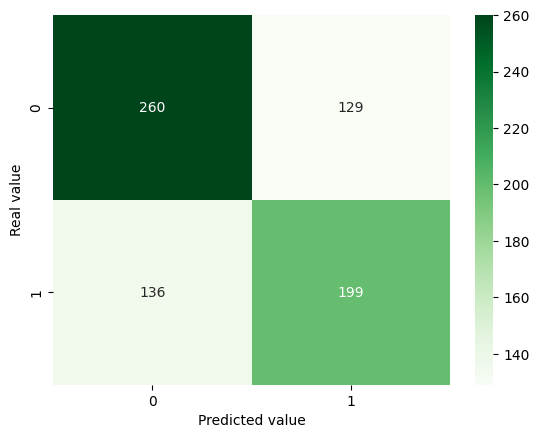

In [360]:
pipeline, y_pred, y_proba, model = optimize_and_train(X_train, y_train, X_test, y_test, n_trials=25)

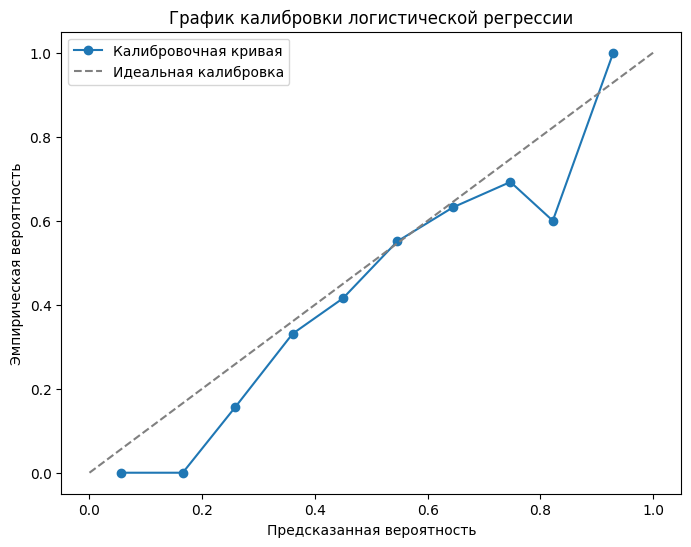

In [362]:
# # Предсказание вероятностей
y_proba = gs_binary.predict_proba(X_test)

# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data['RedFighter'].iloc[:test_size],
    'BlueFighter': data['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': data['Result'].iloc[:test_size]
})


# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.73      0.68       389
           1       0.62      0.52      0.56       335

    accuracy                           0.63       724
   macro avg       0.63      0.62      0.62       724
weighted avg       0.63      0.63      0.63       724



Text(0.5, 23.52222222222222, 'predicted value')

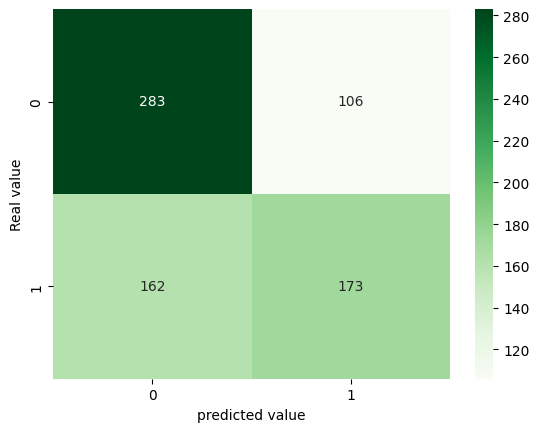

In [363]:
from sklearn.calibration import CalibratedClassifierCV

model = gs_binary.best_estimator_
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

### Feature Engineering

In [364]:
# Создаем новые признаки
def create_new_features(df): 
    df_copy = df.copy()   
    df_copy['Age_diff'] = df_copy['RedAge'] - df_copy['BlueAge']
    df_copy['Height_diff'] = df_copy['RedHeightCms'] - df_copy['BlueHeightCms']
    df_copy['Reach_diff'] = df_copy['RedReachCms'] - df_copy['BlueReachCms']
    df_copy['Weight_diff'] = df_copy['RedWeightLbs'] - df_copy['BlueWeightLbs']
    df_copy['Red_wins_loss_diff'] = df_copy['RedWins'] - df_copy['RedLosses']
    df_copy['Blue_wins_loss_diff'] = df_copy['BlueWins'] - df_copy['BlueLosses']
    df_copy['Red_Blue_Wins_diff'] = df_copy['RedWins'] - df_copy['BlueWins']
    df_copy['Red_Blue_Loss_diff'] = df_copy['RedLosses'] - df_copy['BlueLosses']
    # Находим разницу между числом побед-поражений для обоих бойцов
    df_copy['Red_Blue_wins_loss_diff'] = df_copy['Red_wins_loss_diff'] - df_copy['Blue_wins_loss_diff']
    # Находим разницу в статистических показателях для обоих бойцов
    df_copy['AvgSigStrLanded_diff'] = df_copy['RedAvgSigStrLanded'] - df_copy['BlueAvgSigStrLanded']
    df_copy['AvgSigStrPct_diff'] = df_copy['RedAvgSigStrPct'] - df_copy['BlueAvgSigStrPct']
    df_copy['TDAvgLanded_diff'] = df_copy['RedAvgTDLanded'] - df_copy['BlueAvgTDLanded']
    df_copy['AvgTDPct_diff'] = df_copy['RedAvgTDPct'] - df_copy['BlueAvgTDPct']
    df_copy['AvgSubAtt_diff'] = df_copy['RedAvgSubAtt'] - df_copy['BlueAvgSubAtt']
    return df_copy

# Находим разницу в текущих сериях побед/поражений для двух бойцов
def red_blue_streak_diff_calc(row):
    if row['RedCurrentWinStreak'] > 0: 
        if row['BlueCurrentWinStreak'] > 0:
            return row['RedCurrentWinStreak'] - row['BlueCurrentWinStreak']
        else:
            return row['RedCurrentWinStreak'] + row['BlueCurrentLoseStreak']
    else:
        if row['BlueCurrentWinStreak'] > 0:
            return -row['RedCurrentLoseStreak'] - row['BlueCurrentWinStreak']
        else:
            return -row['RedCurrentLoseStreak'] + row['BlueCurrentLoseStreak']     

In [365]:
# Убираем исходные признаки и оставляем только созданные
def drop_features(df):
    df_copy = df.copy()
    df_copy = df_copy.drop(columns=[
                          'RedAge',
                          'RedHeightCms',
                          'RedReachCms',
                          'RedWeightLbs',
                          'BlueAge',
                          'BlueHeightCms',
                          'BlueReachCms',
                          'BlueWeightLbs',
                          'RedWins',
                          'RedLosses',
                          'BlueWins',
                          'BlueLosses',
                          'RedCurrentWinStreak',
                          'RedCurrentLoseStreak',
                          'RedTotalRoundsFought',
                          'BlueCurrentWinStreak',
                          'BlueCurrentLoseStreak',
                        #   'Red_wins_loss_diff',
                        #   'Blue_wins_loss_diff',                                     
                        #   'WeightClass',
                          'RedAvgSigStrLanded',
                          'RedAvgSigStrPct',
                          'BlueAvgSigStrLanded',
                          'BlueAvgSigStrPct',
                          'RedAvgTDLanded',
                          'RedAvgTDPct', 
                          'BlueAvgTDLanded',
                          'BlueAvgTDPct',
                          'RedAvgSubAtt',                          
                          'BlueAvgSubAtt',
                          'Gender',
                          'NumberOfRounds',
                          'RedWinsBySubmission',
                          'BlueWinsBySubmission',
                          'RedWinsByDecision',
                          'RedWinsByKO/TKO',
                          'BlueWinsByDecision',
                          'BlueWinsByKO/TKO',
                          'BlueTotalRoundsFought'                                    
                          ], axis=1)
    return df_copy

In [370]:
data_featured = create_new_features(data_final)
data_featured['Red_Blue_curr_streak_diff'] = data_featured.apply(red_blue_streak_diff_calc, axis=1)
data_featured = drop_features(data_featured)

In [371]:
data_featured

,BlueFighter,RedFighter,WeightClass,RedStance,BlueStance,Result,Age_diff,Height_diff,Reach_diff,Weight_diff,...,Blue_wins_loss_diff,Red_Blue_Wins_diff,Red_Blue_Loss_diff,Red_Blue_wins_loss_diff,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,Red_Blue_curr_streak_diff
FightNumber,,,,,,,,,,,,,,,,,,,,,
0,Kai Asakura,Alexandre Pantoja,0,1.0,1.0,1,3,-7.62,-5.08,0,...,0,12,3,9,4.4100,0.490,2.6100,0.470,0.8000,6
1,Ian Machado Garry,Shavkat Rakhmonov,4,1.0,1.0,0,3,-5.08,7.62,0,...,8,-2,0,-2,-1.3800,0.060,0.7200,-0.260,1.5000,-2
2,Alexander Volkov,Ciryl Gane,7,1.0,1.0,0,-2,-7.62,2.54,-5,...,8,-3,-2,-1,0.3600,0.030,0.1300,-0.420,0.3000,-3
3,Kron Gracie,Bryce Mitchell,2,0.0,0.0,0,-6,2.54,0.00,0,...,-1,6,0,6,-1.4400,0.140,2.9800,0.160,1.1000,1
4,Dooho Choi,Nate Landwehr,2,1.0,1.0,1,3,-2.54,5.08,0,...,1,1,0,1,1.8400,-0.070,0.2500,0.040,0.2000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,Rory MacDonald,Carlos Condit,4,1.0,1.0,0,6,5.08,-2.54,0,...,1,0,1,-1,-4.4400,-0.030,0.0000,-0.035,0.0000,0
6484,Mike Guymon,Yoshiyuki Yoshida,4,0.0,1.0,1,0,-2.54,-10.16,0,...,-1,2,1,1,-3.2500,0.005,0.2500,0.250,0.5000,0
6485,John Salter,Jason MacDonald,5,1.0,0.0,1,9,5.08,15.24,0,...,-1,5,4,1,2.9231,0.508,-0.2000,-0.018,1.0000,-1


In [373]:
# X_to_export = pd.concat([X_train_featured],axis=0)

data_featured.drop(['BlueFighter','RedFighter'], axis=1).to_csv('data_featured_3634.csv')

# y_to_export = pd.concat([y_test, y_train], axis=0)
# y_to_export.to_csv('y_2000.csv')

In [377]:
X = data_featured.drop(columns=['BlueFighter','RedFighter', 'Result'], axis=1)

X_train_featured = X.loc[test_size:, :]
y_train = data_final.loc[test_size:, 'Result']

X_test_featured = X.loc[:test_size, :]
y_test = data_final.loc[:test_size, 'Result']

In [378]:
X_train_featured

,WeightClass,RedStance,BlueStance,Age_diff,Height_diff,Reach_diff,Weight_diff,Red_wins_loss_diff,Blue_wins_loss_diff,Red_Blue_Wins_diff,Red_Blue_Loss_diff,Red_Blue_wins_loss_diff,AvgSigStrLanded_diff,AvgSigStrPct_diff,TDAvgLanded_diff,AvgTDPct_diff,AvgSubAtt_diff,Red_Blue_curr_streak_diff
FightNumber,,,,,,,,,,,,,,,,,,
724,2,1.0,0.0,-2,-2.54,5.08,0,1,2,0,1,-1,-1.5400,-0.150,1.9900,0.440,0.2000,-1
725,0,1.0,1.0,-6,2.54,2.54,0,1,-3,1,-3,4,-1.5700,0.030,2.6300,0.360,0.0000,4
726,2,1.0,0.0,3,0.00,-2.54,0,0,-1,2,1,1,0.4000,-0.090,-2.0700,0.310,-1.1000,0
727,3,1.0,1.0,-5,2.54,0.00,0,-2,-1,-1,0,-1,0.9400,0.190,-0.9100,-0.240,0.2000,0
728,0,1.0,0.0,11,0.00,-5.08,0,-1,0,3,4,-1,1.0700,0.100,-2.0000,-0.220,-0.5000,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,4,1.0,1.0,6,5.08,-2.54,0,0,1,0,1,-1,-4.4400,-0.030,0.0000,-0.035,0.0000,0
6484,4,0.0,1.0,0,-2.54,-10.16,0,0,-1,2,1,1,-3.2500,0.005,0.2500,0.250,0.5000,0
6485,5,1.0,0.0,9,5.08,15.24,0,0,-1,5,4,1,2.9231,0.508,-0.2000,-0.018,1.0000,-1


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/neuralist/DS&M

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       389
           1       0.59      0.65      0.62       335

    accuracy                           0.63       724
   macro avg       0.63      0.63      0.63       724
weighted avg       0.63      0.63      0.63       724



Text(0.5, 23.52222222222222, 'predicted value')

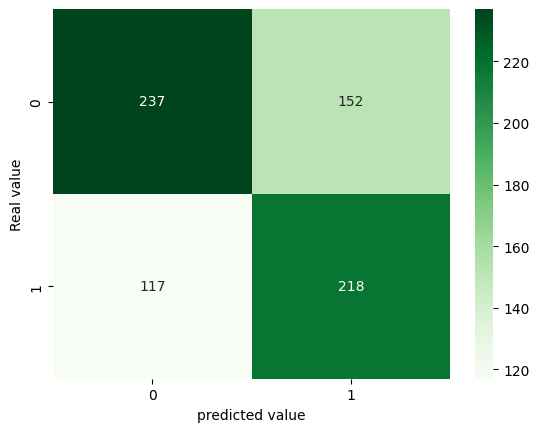

In [379]:
# Обучаем pipeline на тренировочных данных
gs_binary.fit(X_train_featured, y_train)

# Делаем прогнозы на тестовых данных
y_pred = gs_binary.predict(X_test_featured)

# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

[I 2025-01-16 00:56:18,242] A new study created in memory with name: no-name-cbb2d975-5bb6-477f-84df-4581aa34a3b6
[I 2025-01-16 00:56:18,338] Trial 0 finished with value: 0.5085739655137612 and parameters: {'penalty': 'l2', 'C': 1856.7213523987057, 'solver': 'liblinear', 'class_weight': None, 'fit_intercept': True}. Best is trial 0 with value: 0.5085739655137612.
[I 2025-01-16 00:56:18,424] Trial 1 finished with value: 0.565200135200356 and parameters: {'penalty': 'l2', 'C': 1161.3644135227312, 'solver': 'liblinear', 'class_weight': 'balanced', 'fit_intercept': False}. Best is trial 1 with value: 0.565200135200356.
[I 2025-01-16 00:56:18,475] Trial 2 finished with value: 0.002957738778634301 and parameters: {'penalty': 'l1', 'C': 0.06743596319767689, 'solver': 'liblinear', 'class_weight': None, 'fit_intercept': True}. Best is trial 1 with value: 0.565200135200356.
[I 2025-01-16 00:56:19,039] Trial 3 finished with value: 0.5087851881009812 and parameters: {'penalty': 'l1', 'C': 113.6700

Best parameters: {'penalty': 'l2', 'C': 0.47222218245895964, 'solver': 'liblinear', 'class_weight': 'balanced', 'fit_intercept': False}
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.61      0.63       389
           1       0.58      0.64      0.61       335

    accuracy                           0.62       724
   macro avg       0.62      0.62      0.62       724
weighted avg       0.63      0.62      0.62       724



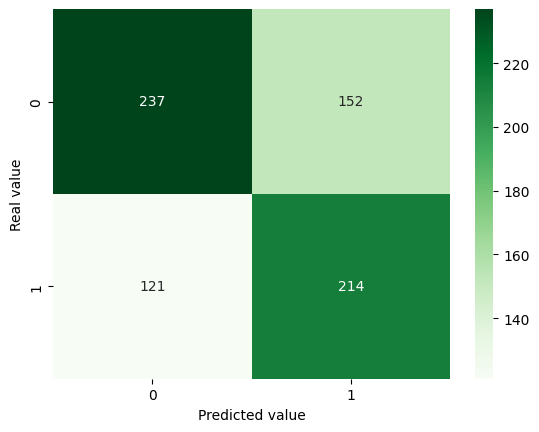

In [380]:
pipeline, y_pred, y_proba, model = optimize_and_train(X_train_featured, y_train, X_test_featured, y_test, n_trials=25)

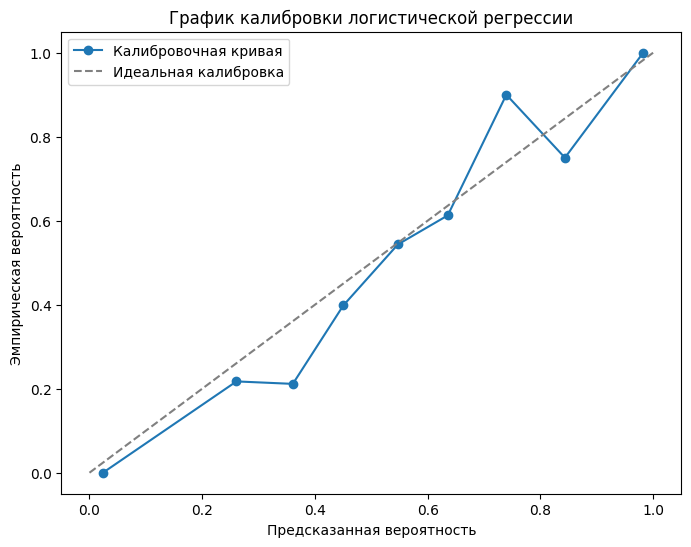

In [381]:
# Предсказание вероятностей
y_proba = gs_binary.predict_proba(X_test_featured)

# Калибровочная кривая
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
prob_true, prob_pred = calibration_curve(y_test, y_proba_positive, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')
plt.xlabel('Предсказанная вероятность')
plt.ylabel('Эмпирическая вероятность')
plt.title('График калибровки логистической регрессии')
plt.legend()

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66       389
           1       0.60      0.62      0.61       335

    accuracy                           0.64       724
   macro avg       0.63      0.63      0.63       724
weighted avg       0.64      0.64      0.64       724



Text(0.5, 23.52222222222222, 'predicted value')

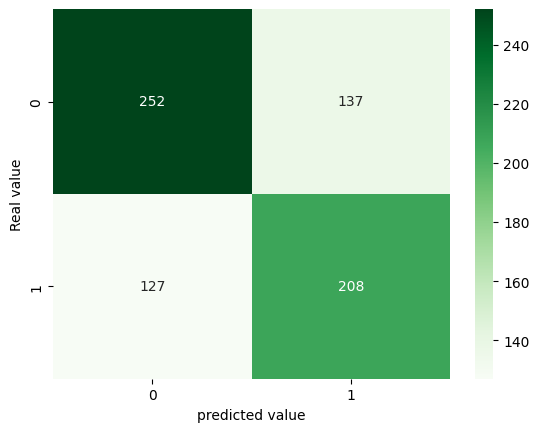

In [382]:
model = gs_binary.best_estimator_
# Предсказываем вероятности
y_proba_positive = y_proba[:, 1]  # Вероятности положительного класса
calibrated_model = CalibratedClassifierCV(estimator=model, method='isotonic', cv='prefit')
calibrated_model.fit(X_test_featured, y_test)
# Предсказанные вероятности после калибровки
calibrated_proba = calibrated_model.predict_proba(X_test_featured)[:, 1]
# # Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, calibrated_proba, n_bins=10, strategy="uniform")

y_pred_calibrated = calibrated_model.predict(X_test_featured)
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred_calibrated),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [383]:
# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': data['RedFighter'].iloc[:test_size],
    'BlueFighter': data['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': data['Result'].iloc[:test_size]
})

results_df['Predicted_Winner'] = (results_df['ProbabilityBlueWins'] > results_df['ProbabilityRedWins']).astype(int)
results_df['Prediction_Errors'] = np.abs(results_df['Predicted_Winner'] - results_df['ActualWinner'])
results_df.iloc[:30, :]

,RedFighter,BlueFighter,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors
FightNumber,,,,,,,
0,Alexandre Pantoja,Kai Asakura,0.713869,0.286131,1,0,1
1,Shavkat Rakhmonov,Ian Machado Garry,0.345507,0.654493,0,1,1
2,Ciryl Gane,Alexander Volkov,0.473378,0.526622,0,1,1
3,Bryce Mitchell,Kron Gracie,0.500850,0.499150,0,0,0
4,Nate Landwehr,Dooho Choi,0.488525,0.511475,1,1,0
5,Dominick Reyes,Anthony Smith,0.622373,0.377627,0,0,0
6,Vicente Luque,Themba Gorimbo,0.425303,0.574697,1,1,0
7,Movsar Evloev,Aljamain Sterling,0.683742,0.316258,0,0,0
8,Randy Brown,Bryan Battle,0.437000,0.563000,1,1,0


In [35]:
featured_stats_columns = ['RedSigStrikesAverage',
                          'BlueSigStrikesAverage',
                          'RedSuccesfullTDAverage',
                          'BlueSuccesfullTDAverage',
                          'Red_Blue_SigStrikAvg_diff',
                          'Red_Blue_SuccTDAvg_diff',
                          'Red_Blue_AvgSubAtt_diff']

In [ ]:
stats_columns_hist(X_train, featured_stats_columns)